In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline
from scipy.integrate import simpson
from scipy.optimize import nnls, lsq_linear
from sklearn.preprocessing import MinMaxScaler

s1 = pd.read_csv('data/processed/s1.csv')
s2 = pd.read_csv('data/processed/s2.csv')

wn = s1.columns.map(float).values

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)

reference_path = os.path.join('data', 'raw', 'Database Raman')

labels  = []
domains = []
spectra = []

for filename in os.listdir(reference_path):
    # avoid non spectra files
    if sum(s.isupper() for s in filename) < 2:
        labels.append(filename.split('.')[0])

        filename = os.path.join(reference_path, filename)
        domains.append(np.loadtxt(filename)[:, 0])
        spectra.append(np.loadtxt(filename)[:, 1])

In [3]:
max_min = []
min_max = []
for domain in domains:
    max_min.append(domain[1])
    min_max.append(domain[-2])
    
np.max(max_min), np.min(min_max)

(226.1141, 1200.811)

In [4]:
max_wn_ind = np.where(wn == 1200)[0][0]
int_domain = wn[:max_wn_ind + 1]

int_spectra = np.zeros((len(spectra), max_wn_ind + 1))
for i, (domain, spectrum) in enumerate(zip(domains, spectra)):
    # avoid negative values (???)
    spectrum = np.where(spectrum < 0, 0, spectrum)
    int_spectra[i] = CubicSpline(domain[1:-1], spectrum[1:-1], extrapolate=False)(int_domain)
    int_spectra[i] = np.nan_to_num(int_spectra[i])
    int_spectra[i] = int_spectra[i] / simpson(int_spectra[i], int_domain)

int_spectra = MinMaxScaler().fit_transform(int_spectra.T).T

In [5]:
s1_renorm = s1.values[:, :max_wn_ind + 1] / simpson(s1.values[:, :max_wn_ind + 1], int_domain)[:, None]
s2_renorm = s2.values[:, :max_wn_ind + 1] / simpson(s2.values[:, :max_wn_ind + 1], int_domain)[:, None]

s1_renorm = MinMaxScaler().fit_transform(s1_renorm.T).T
s2_renorm = MinMaxScaler().fit_transform(s2_renorm.T).T

In [127]:
non_zero = []
labels_dist = []
residuals = []
lss = []
X = np.zeros((121, 61))
for i in range(121):
#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 6))
    ls, res = nnls(int_spectra.T, s1_renorm[i], maxiter=1000)
    lss.append(ls / np.sum(ls))
    residuals.append(res)
    
#     ax1.plot(int_domain, s1_renorm[i], label='original')
#     ax1.plot(int_domain, int_spectra.T.dot(ls), label='reconstructed')
#     ax1.legend()
#     ax1.grid()
    
    ls = np.where((ls / np.sum(ls)) <= .15, 0, ls)
    labels_dist.append(np.sum(np.nonzero(ls)[0]))
    non_zero.append(np.nonzero(ls)[0].shape[0])
    X[i] = ls / np.sum(ls)
#     ax2.scatter(np.arange(1, 62), ls / np.sum(ls))
#     ax2.grid()
    
#     plt.show()

/tmp/ipykernel_23013/2890791271.py:20: RuntimeWarning: invalid value encountered in divide
  X[i] = ls / np.sum(ls)


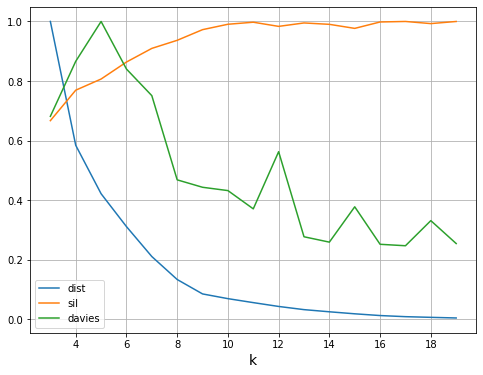

In [181]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score

X = np.nan_to_num(X, nan=-1)

distortions = []
silhouette = []
davies = []
for k in range(3, 20):
    kmeans = KMeans(n_clusters=k, max_iter=10000, tol=1e-6, random_state=0).fit(X)
    labels = kmeans.labels_
    distortions.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X, labels))
    davies.append(davies_bouldin_score(X, labels))

#     print(k, round(calinski_harabasz_score(X, labels), 5), 
#              round(silhouette_score(X, labels), 5),
#              round(davies_bouldin_score(X, labels), 5))

plt.plot(np.arange(3, 20), np.array(distortions) / max(distortions), label='dist')
plt.plot(np.arange(3, 20), np.array(silhouette) / max(silhouette), label='sil')
plt.plot(np.arange(3, 20), np.array(davies) / max(davies), label='davies')
plt.xlabel('k', fontsize=14)
plt.legend()
plt.grid()

In [178]:
np.ediff1d(distortions)

array([-11.70579186,  -4.5790511 ,  -3.10803494,  -2.82979503,
        -2.17113994,  -1.36345938,  -0.44627504,  -0.37517954,
        -0.36235873,  -0.30103874,  -0.20360093,  -0.19060482,
        -0.16506889,  -0.10617253,  -0.06316812,  -0.05988631])

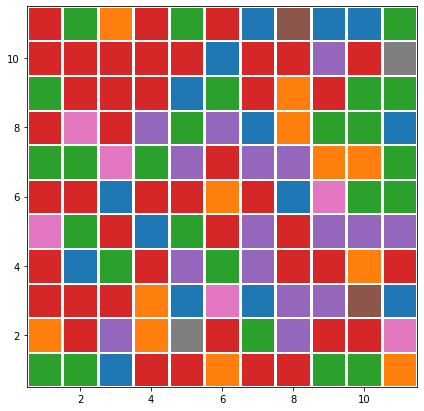

In [182]:
x, y = np.meshgrid(np.arange(1, 12), np.arange(1, 12))

label_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:purple',
    5 : 'tab:brown',
    6 : 'tab:pink',
    7 : 'tab:gray',
    8 : 'tab:cyan',
}

plt.figure(figsize=(7, 7))
kmeans = KMeans(n_clusters=8, max_iter=10000, tol=1e-6, random_state=0).fit(X)
labels = kmeans.predict(X)

colors = np.array([label_to_color[i] for i in labels])

plt.scatter(x, y, c=colors, s=1000, marker='s')
plt.show()

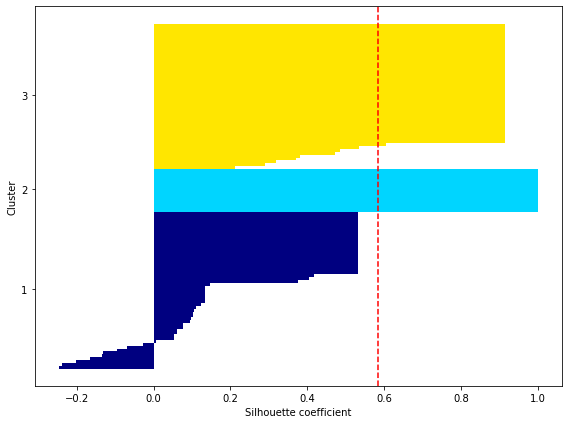

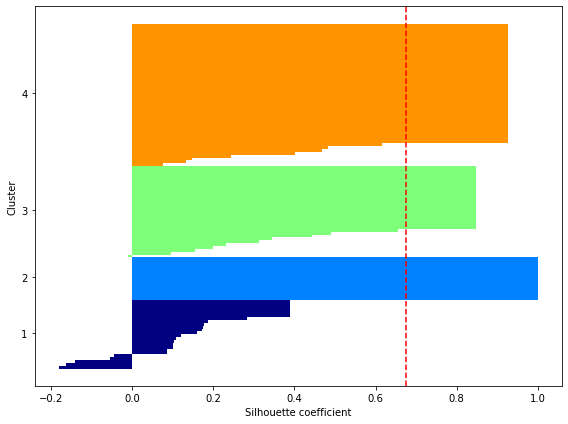

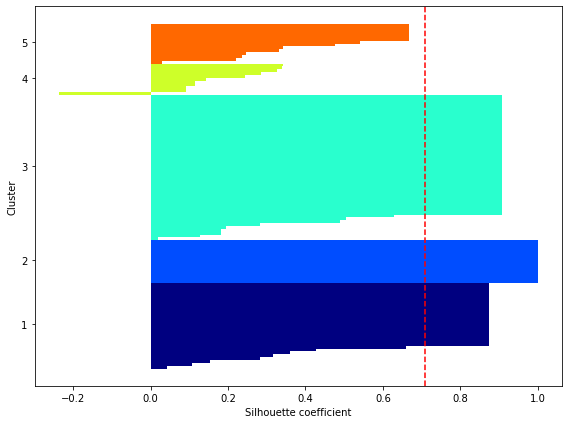

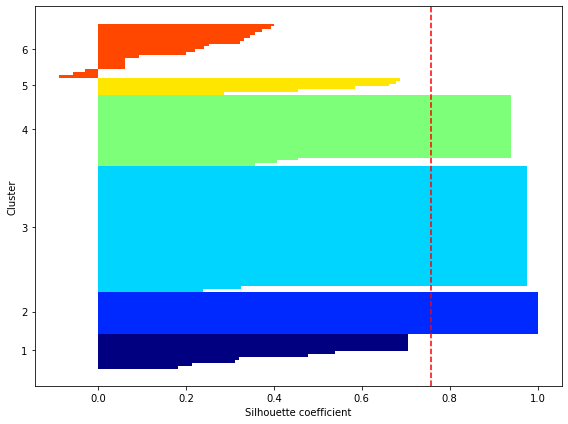

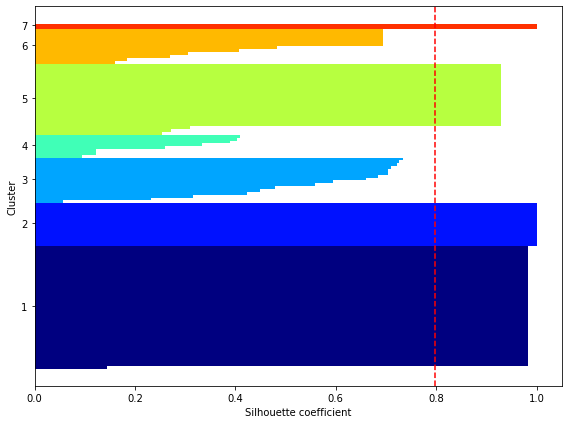

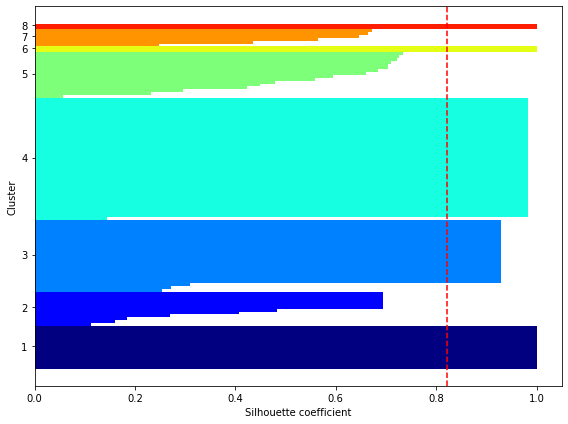

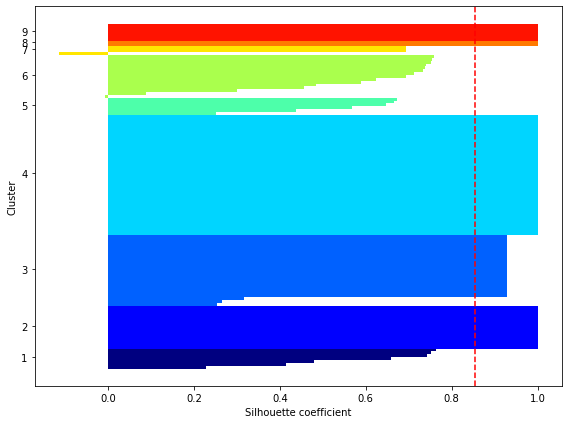

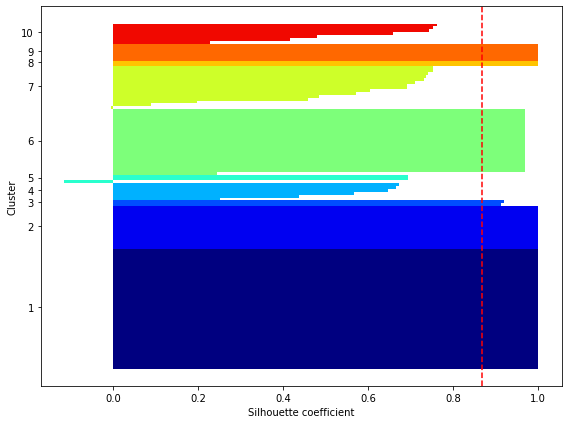

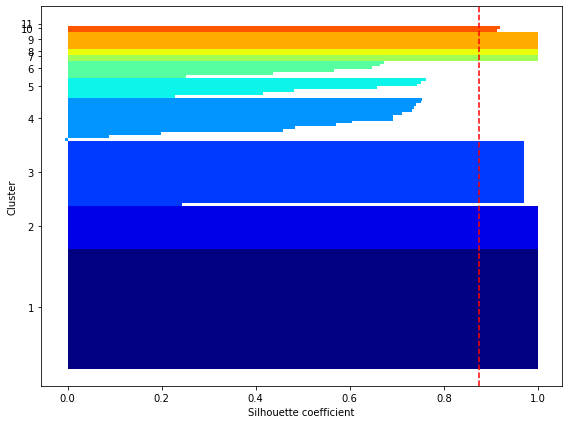

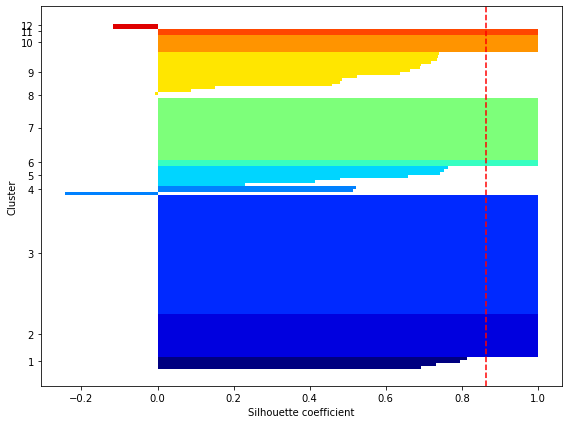

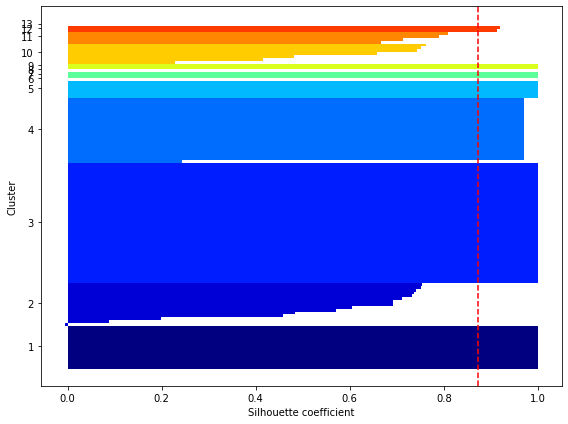

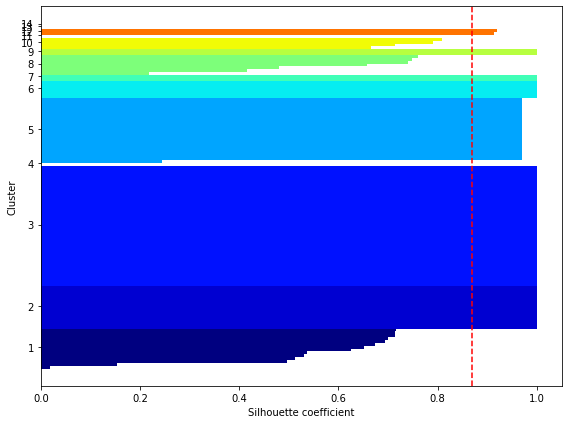

In [142]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

for i in range(3, 15):
    kmeans = KMeans(n_clusters=i, max_iter=10000, tol=1e-6, random_state=0).fit(X)
    labels = kmeans.predict(X)

    cluster_labels = np.unique(labels)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(X, labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):

        c_silhouette_vals = silhouette_vals[labels == c]
        c_silhouette_vals.sort()

        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)

        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, 
                 height=1.0, edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)

    silhouette_avg = np.mean(silhouette_vals)

    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

In [124]:
non_zero = np.array(non_zero)
lss = np.array(lss)
residuals = np.array(residuals)
labels_dist = np.array(labels_dist)

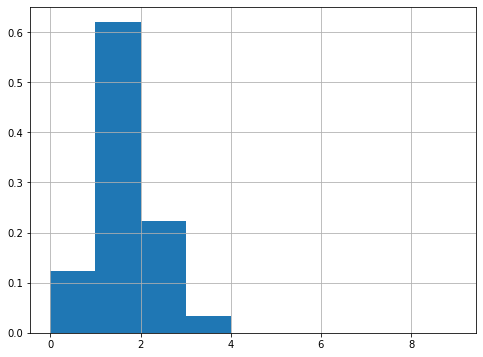

In [118]:
plt.hist(non_zero, bins=np.arange(10), density=True)
plt.grid()

121


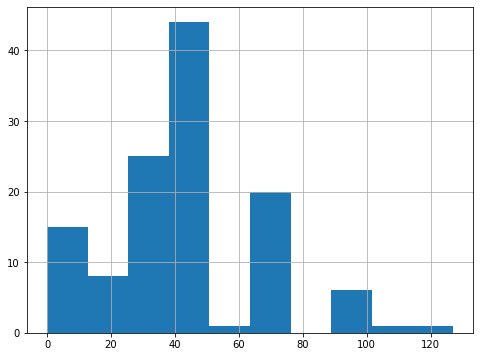

In [125]:
print(len(labels_dist))
np.where((non_zero > 0) & (non_zero < 4) & (residuals < 3))[0].shape[0] / residuals.shape[0]
plt.hist(labels_dist)
plt.grid()

In [126]:
len(set(labels_dist))

15

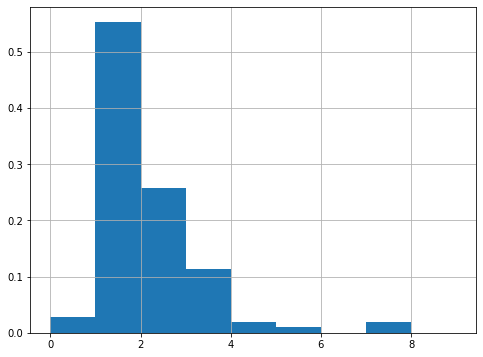

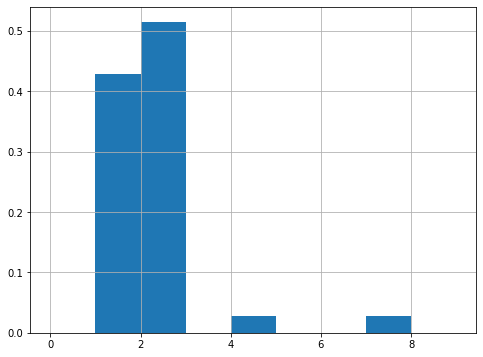

In [88]:
# twos = np.where((np.array(residuals) < 3) & (np.array(non_zero) > 0) & (np.array(non_zero) < 4))[0]
for i in [1, 2]:
    twos = np.where(non_zero == i)[0]
    plt.hist(residuals[twos], np.arange(10), density=True)
    plt.grid()
    plt.show()

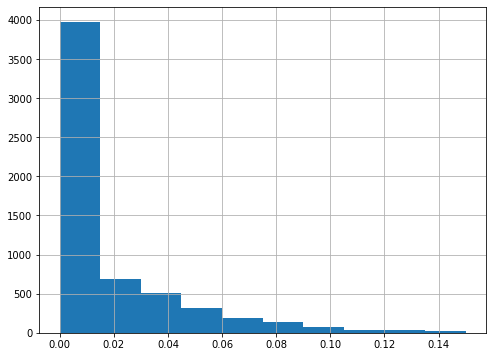

In [84]:
plt.hist(lss[np.where(non_zero == 0)[0]].flatten())
plt.grid()

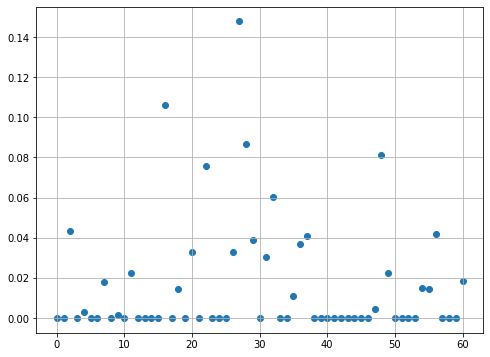

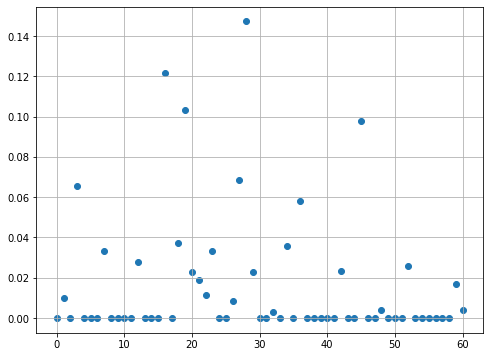

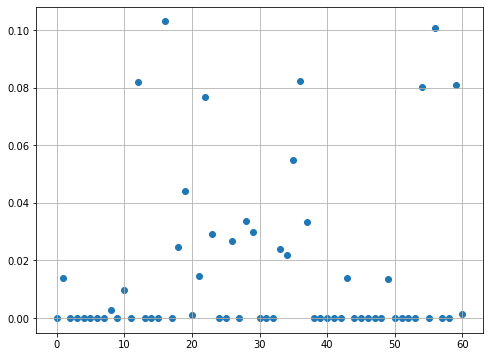

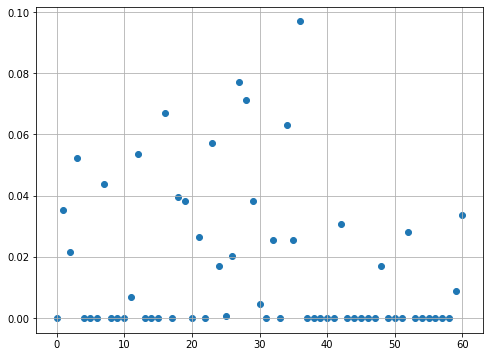

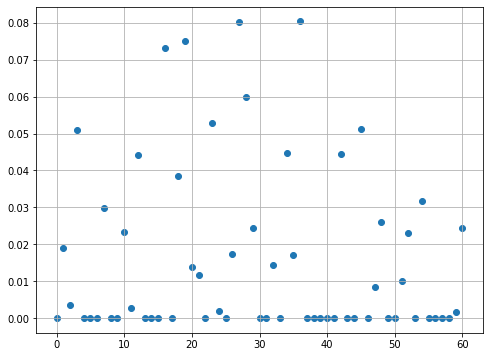

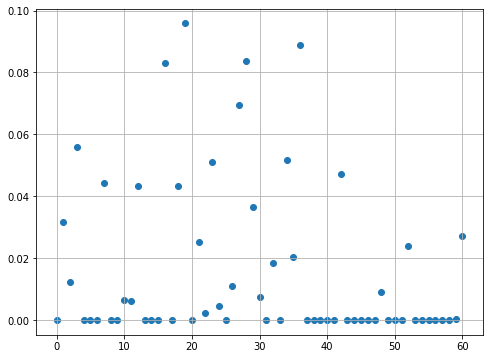

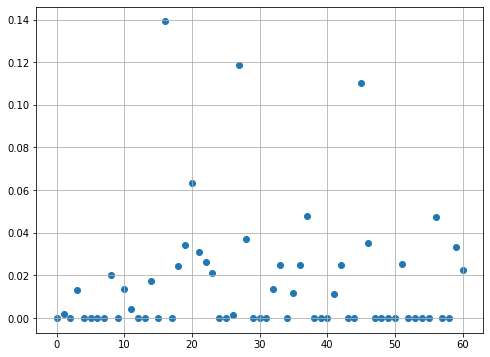

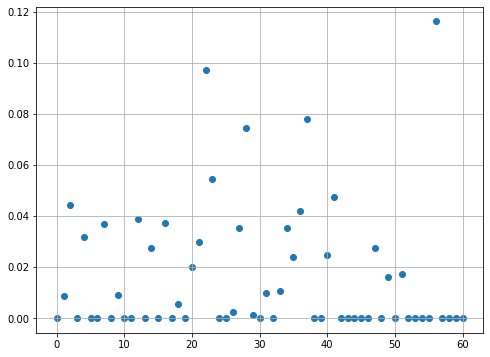

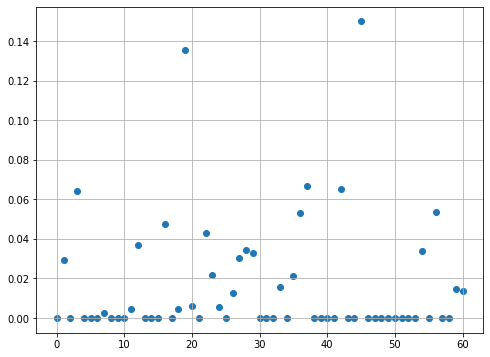

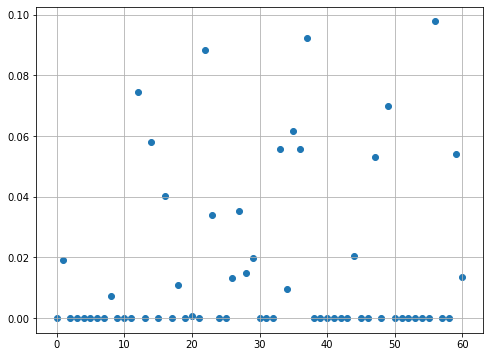

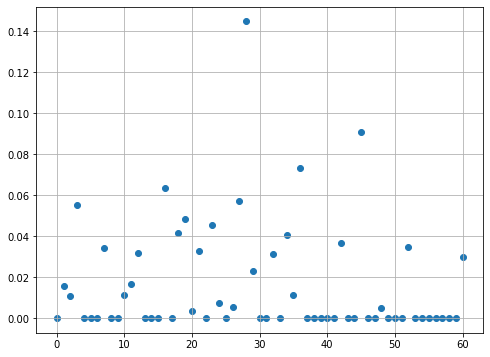

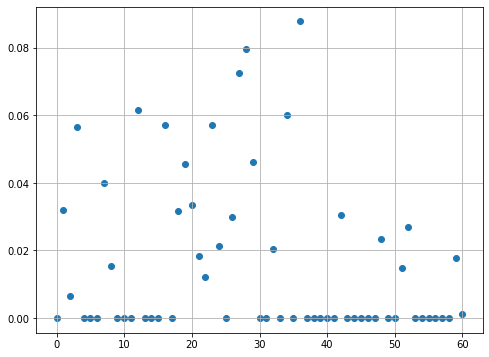

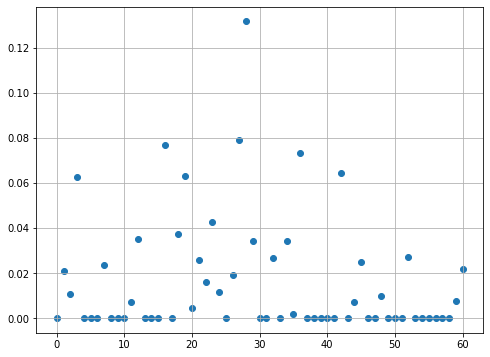

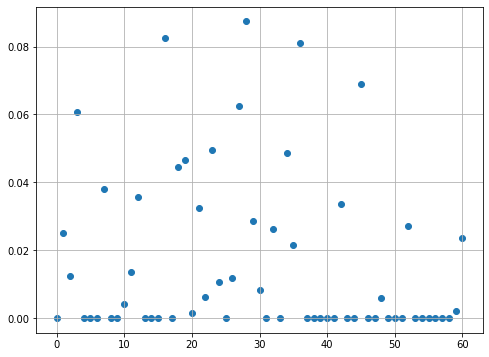

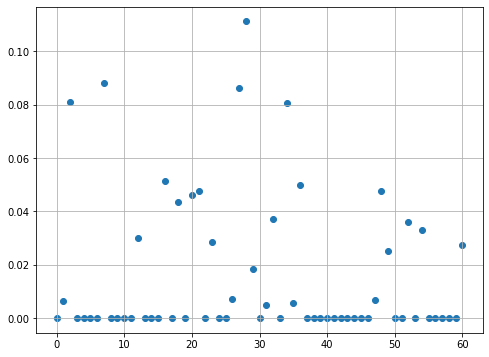

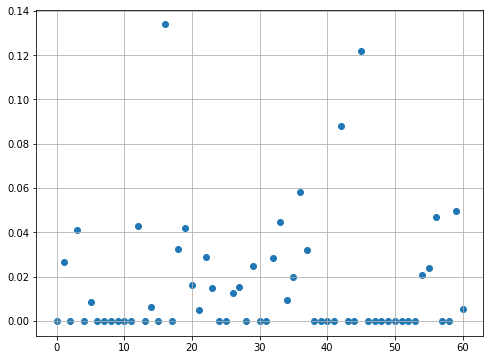

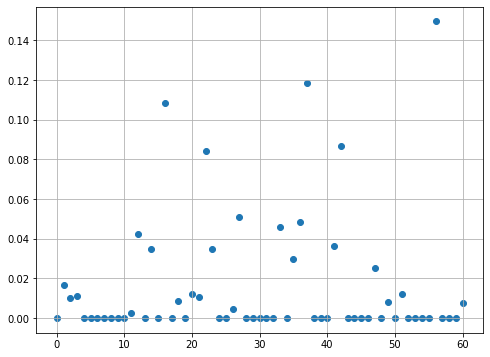

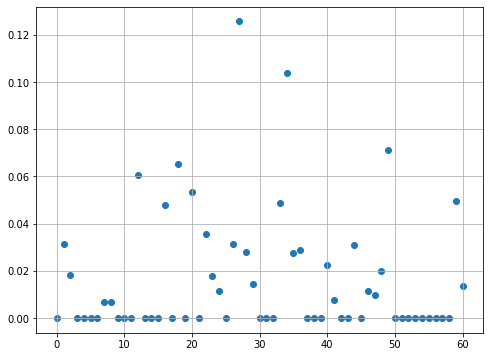

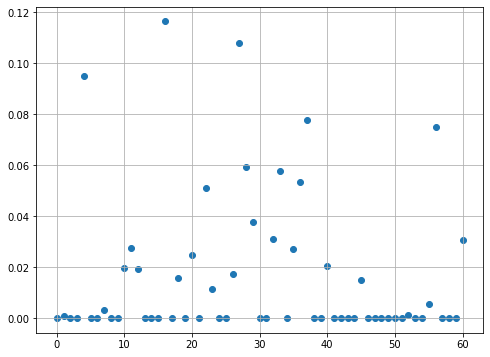

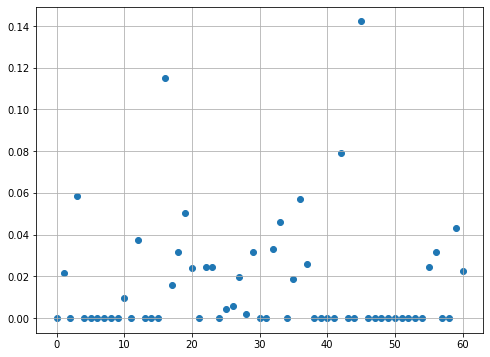

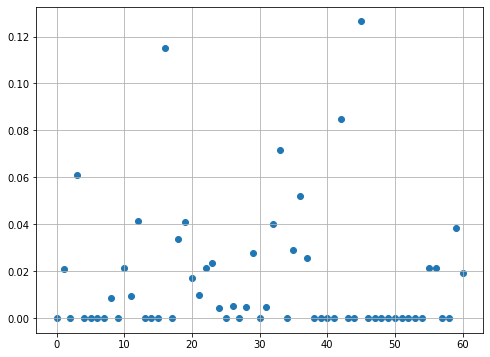

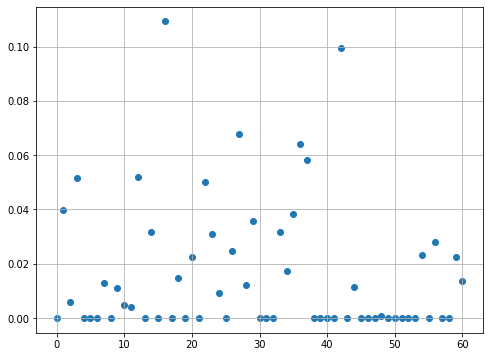

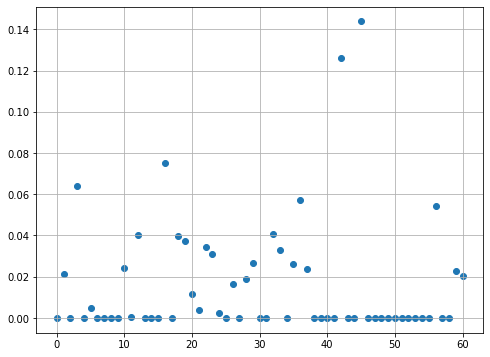

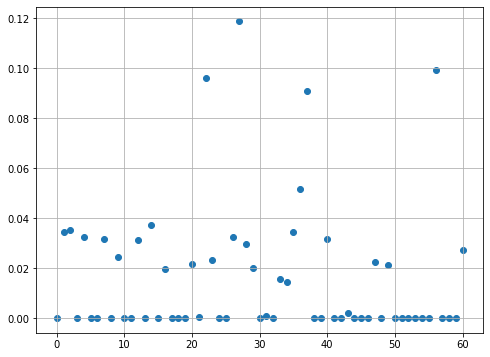

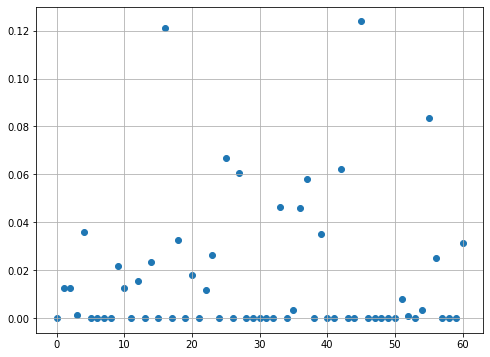

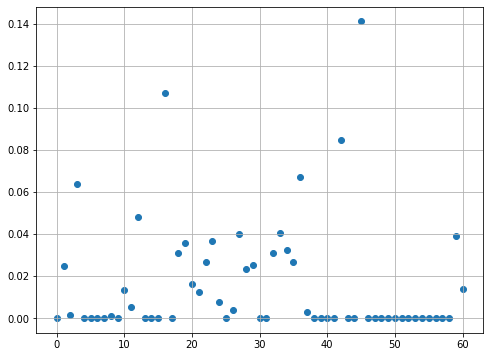

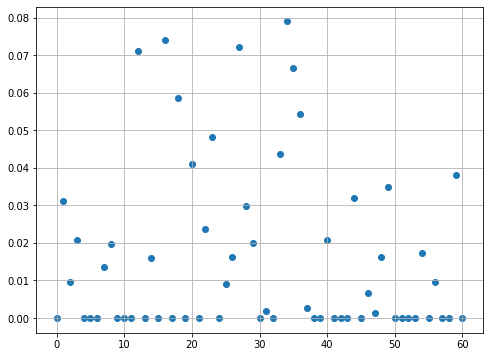

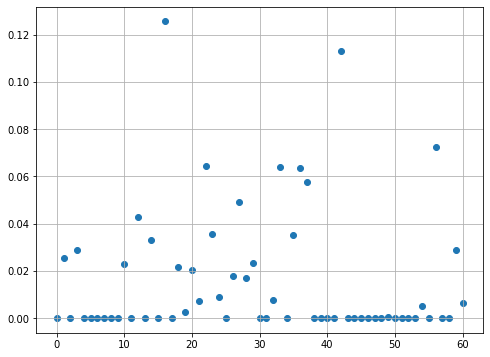

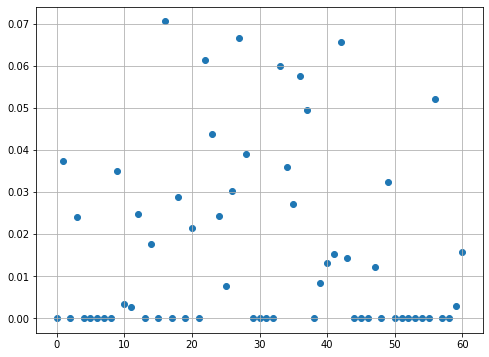

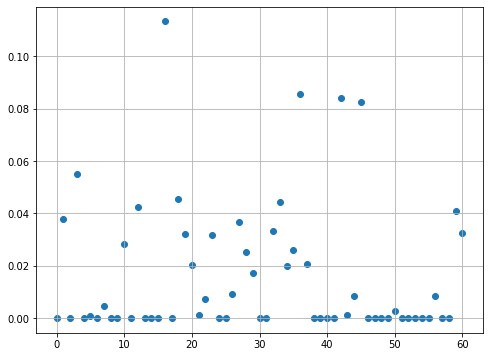

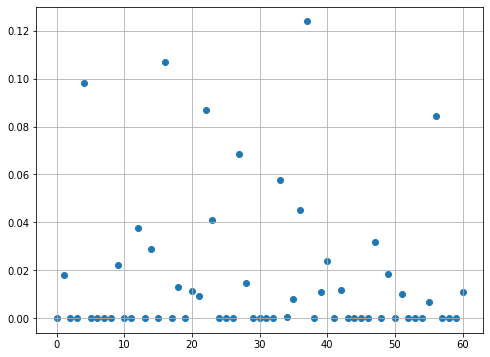

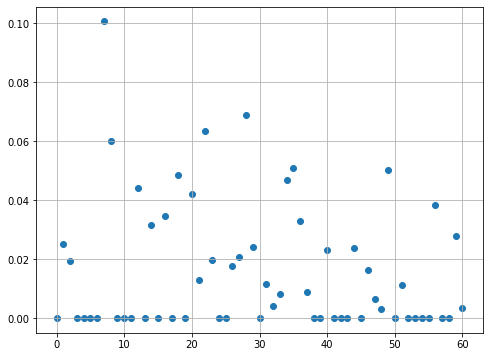

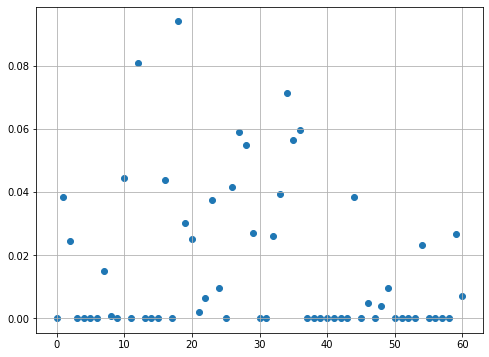

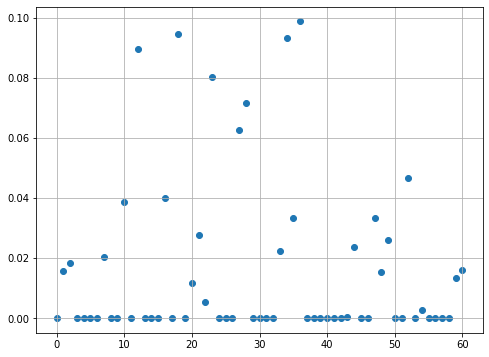

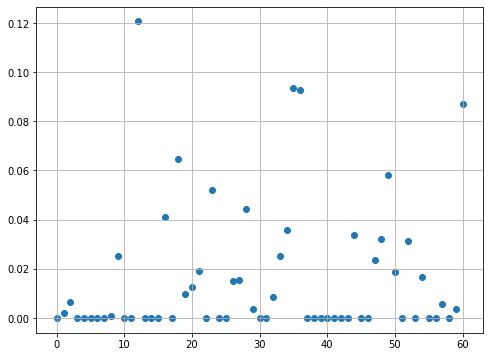

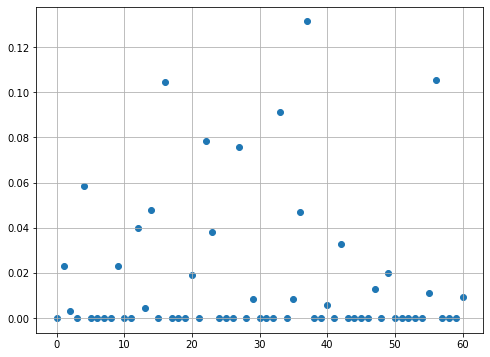

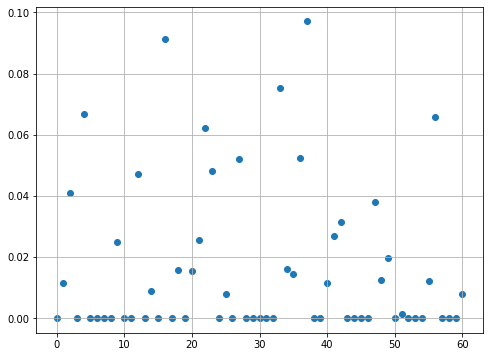

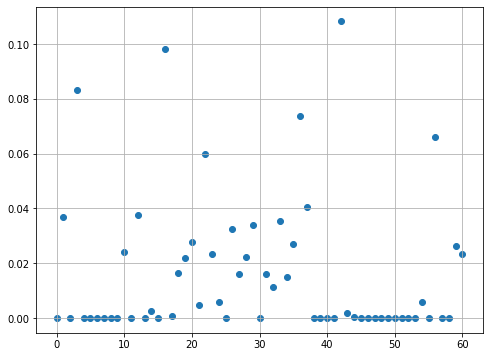

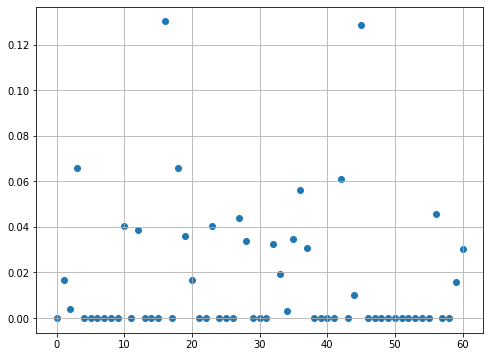

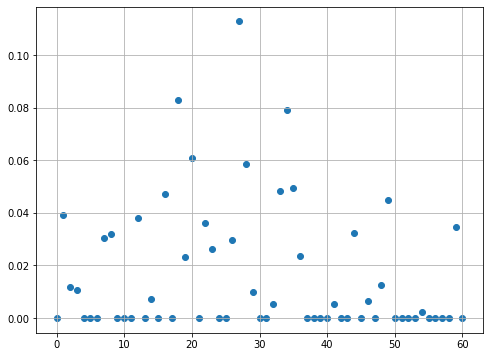

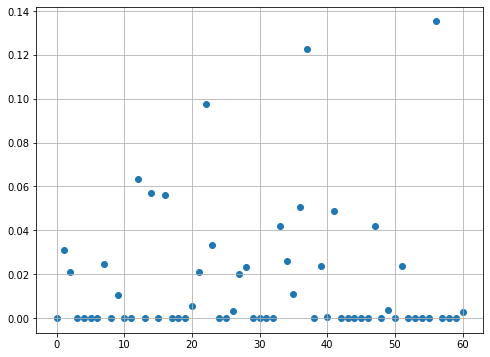

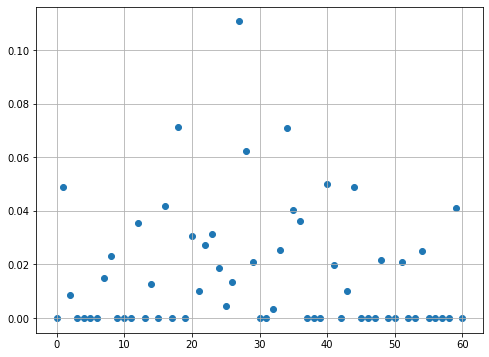

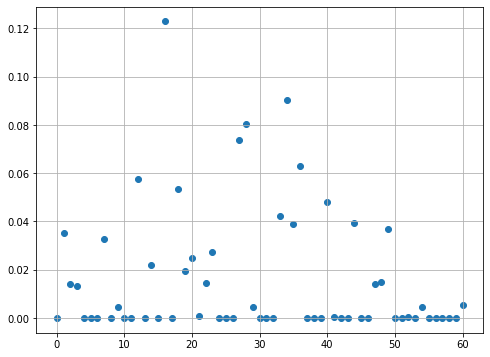

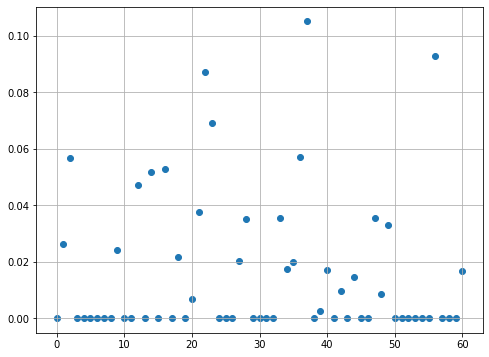

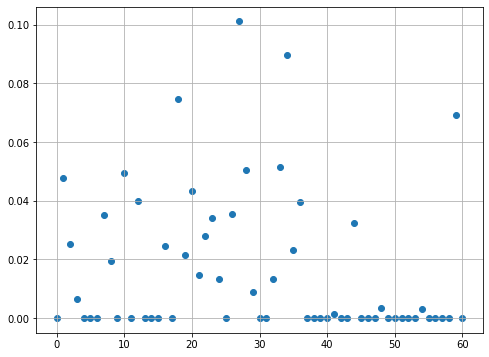

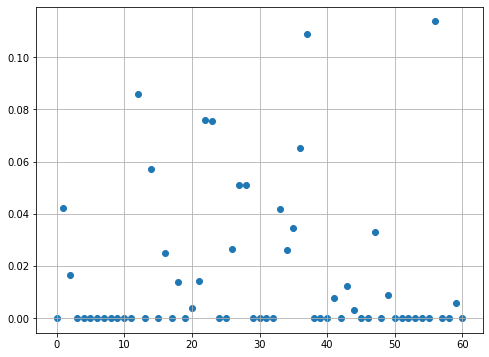

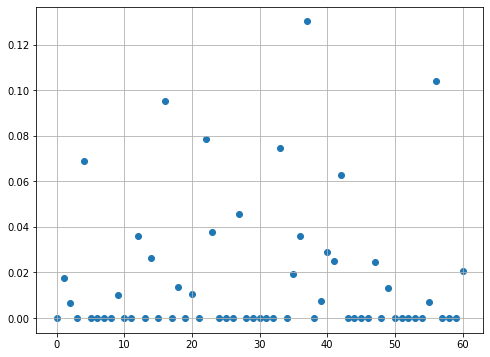

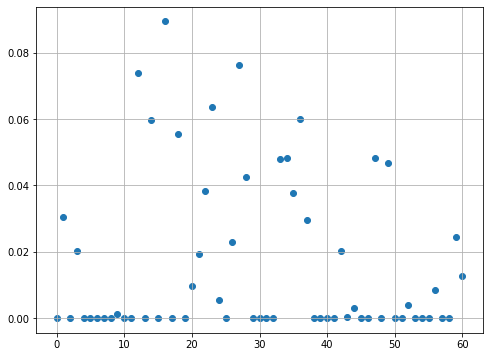

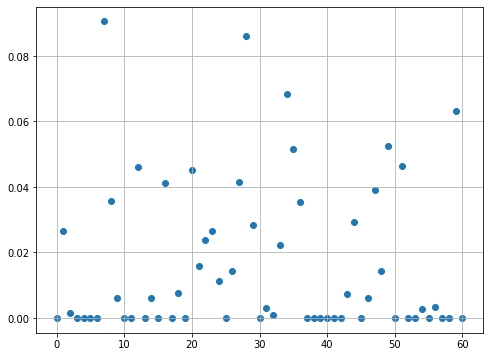

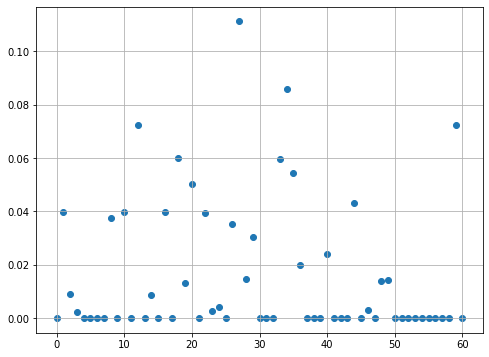

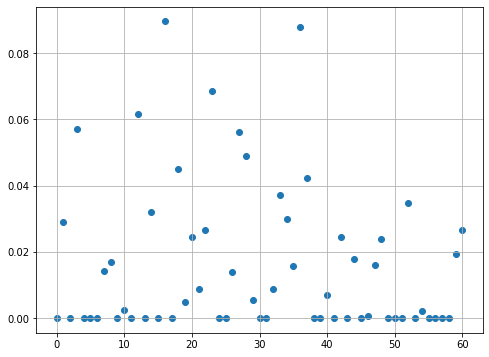

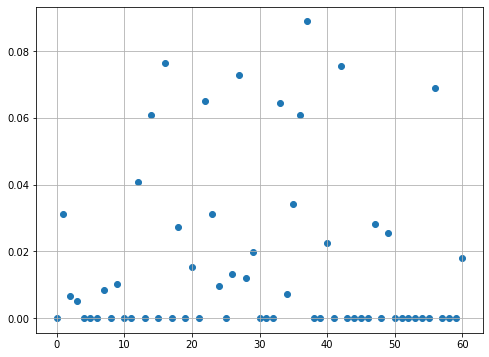

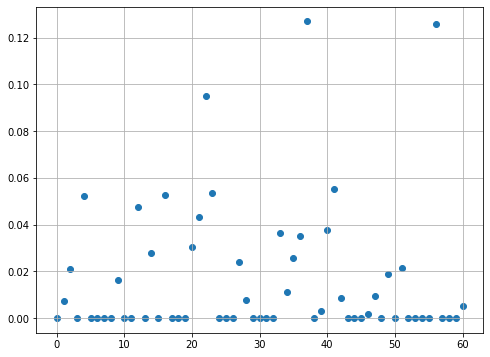

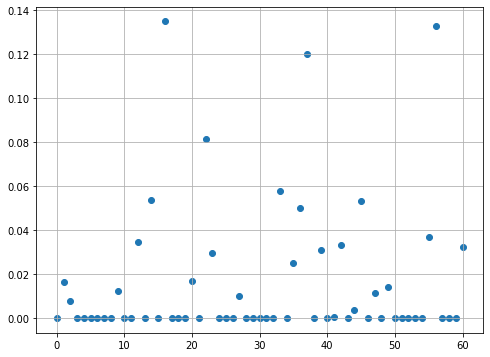

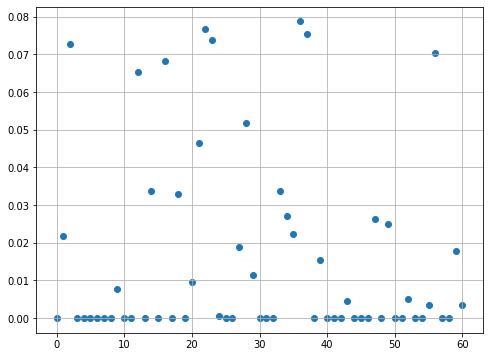

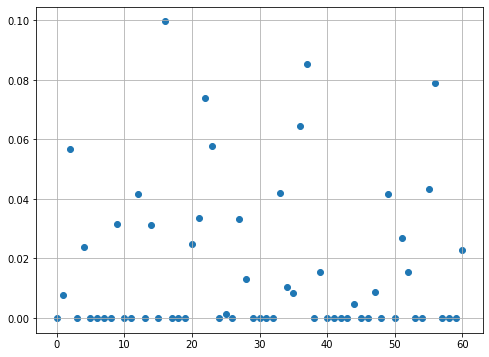

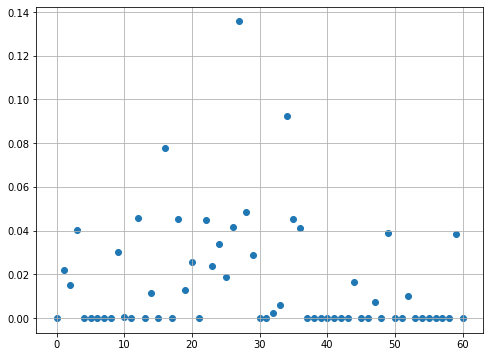

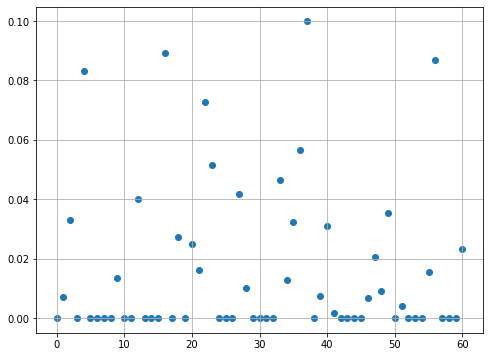

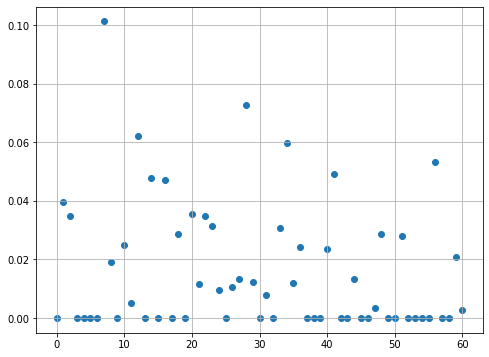

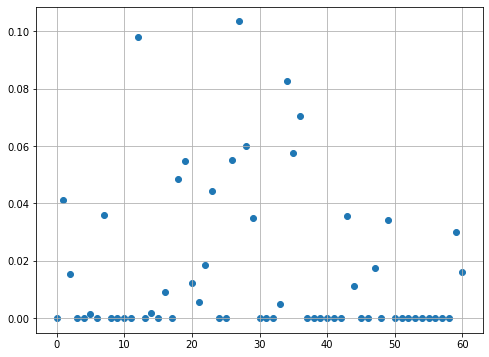

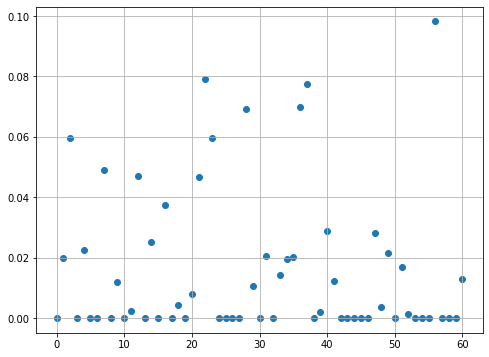

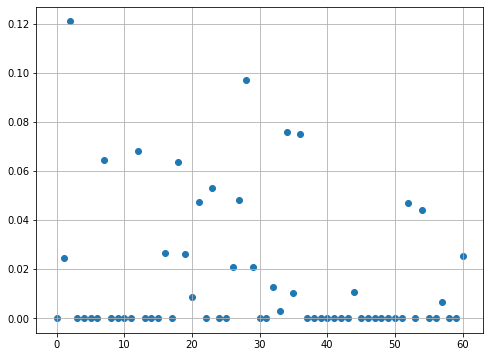

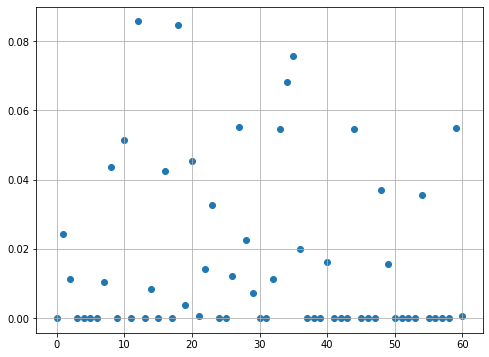

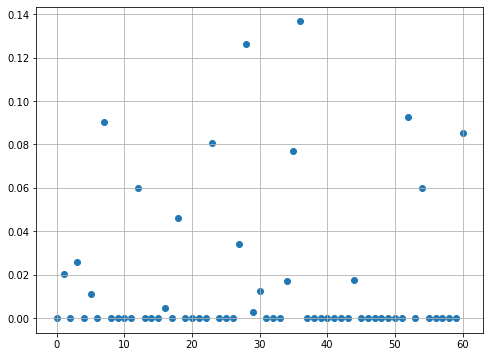

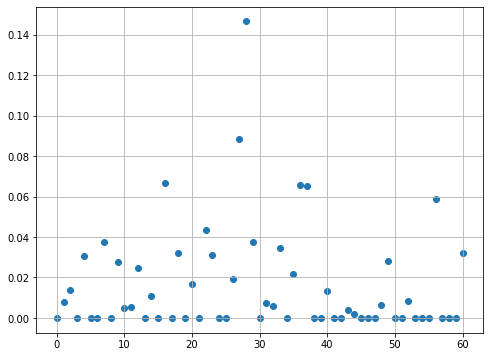

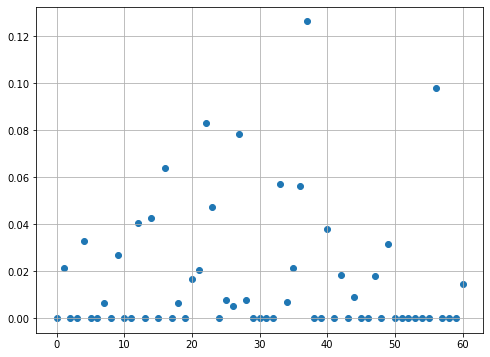

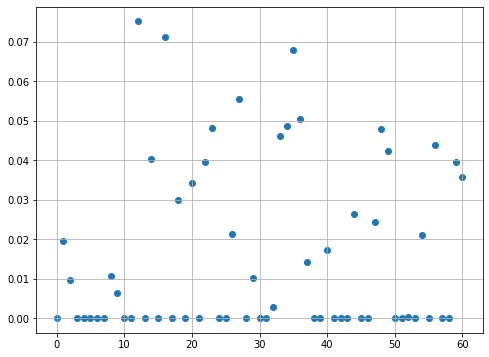

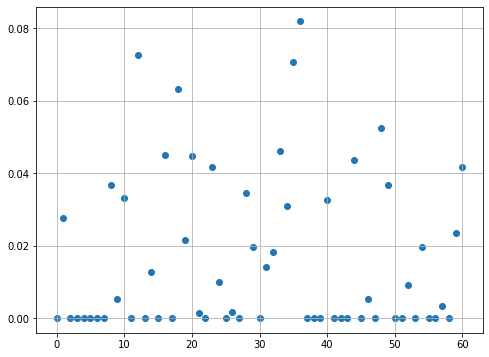

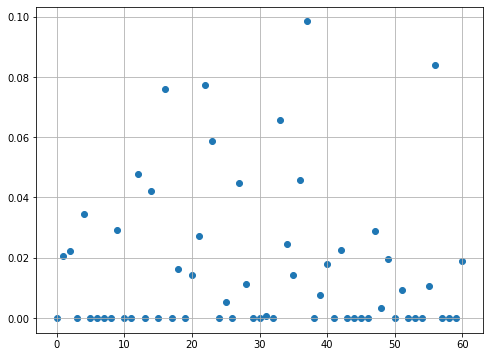

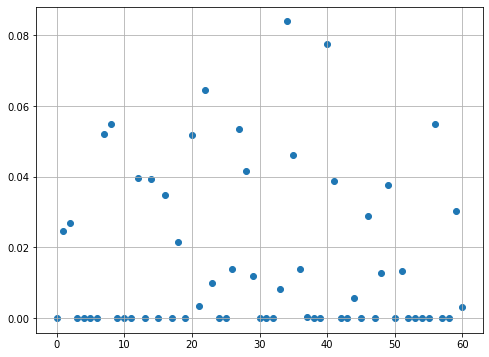

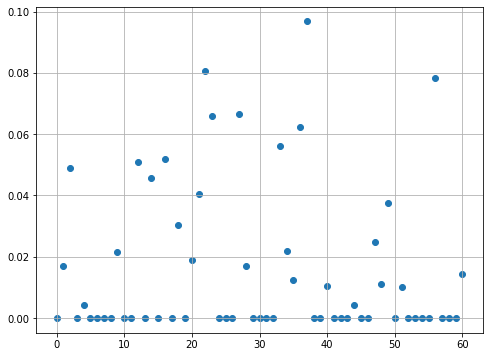

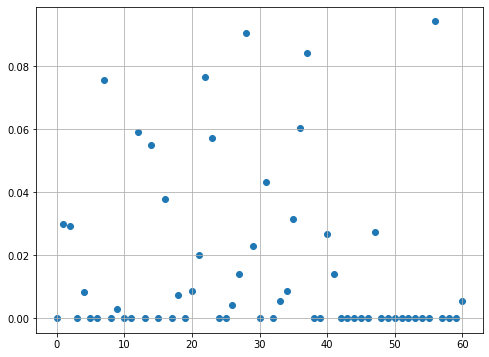

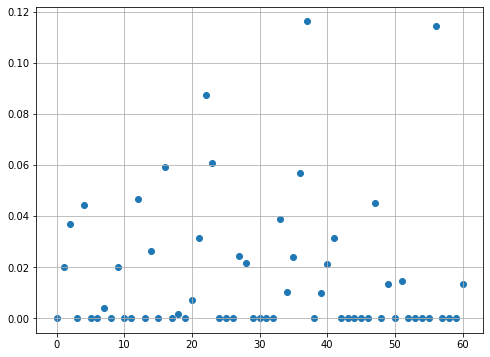

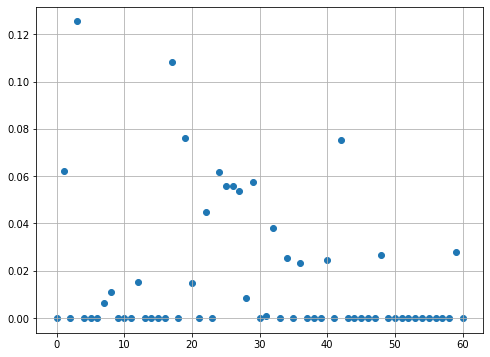

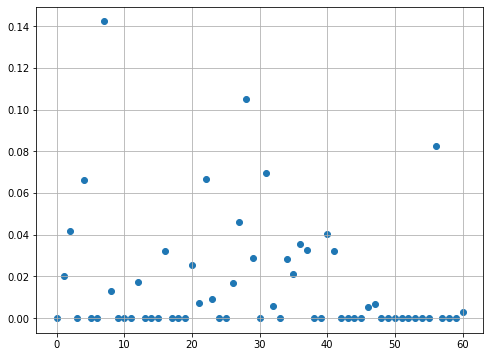

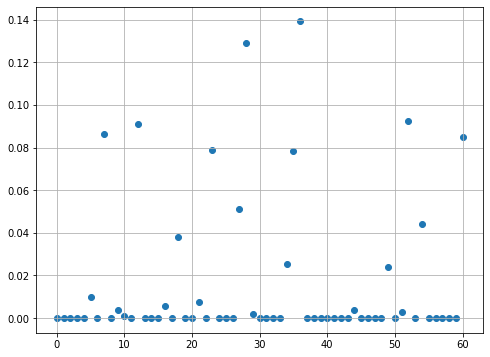

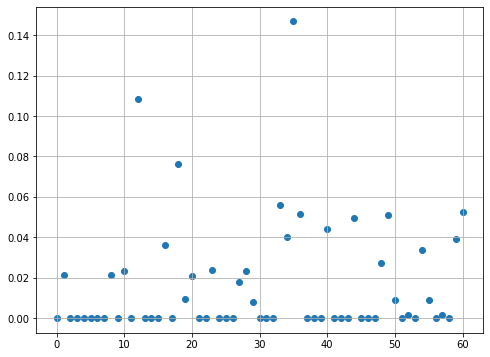

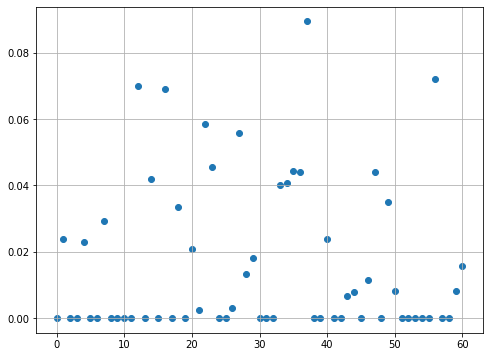

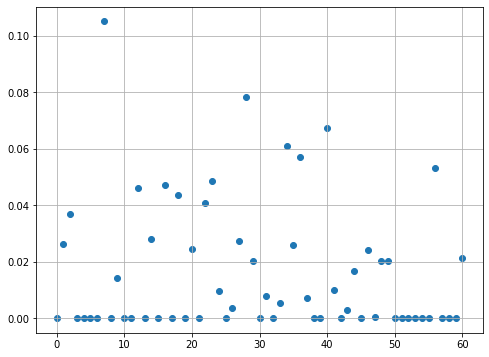

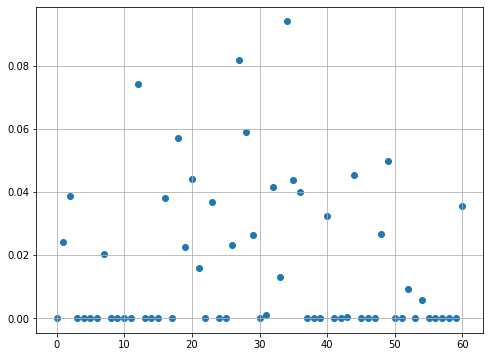

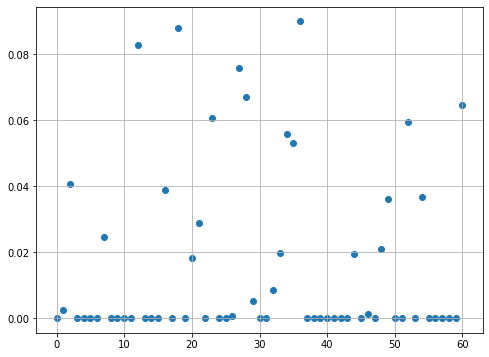

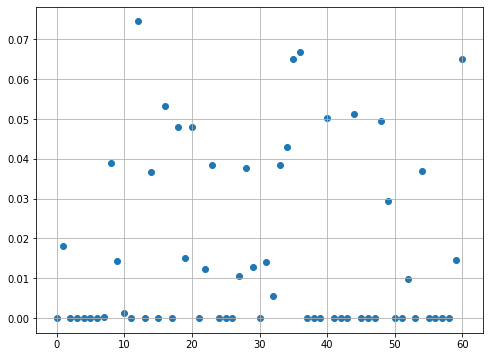

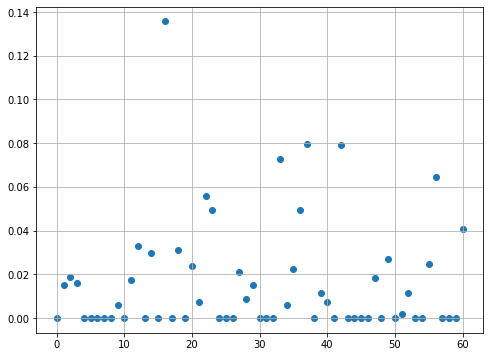

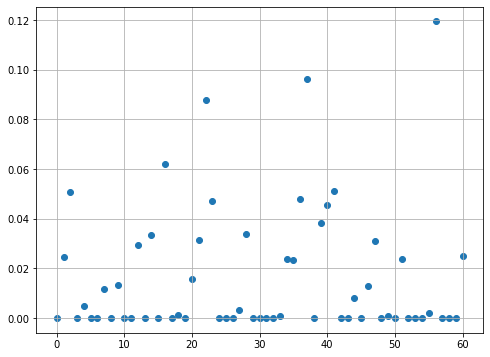

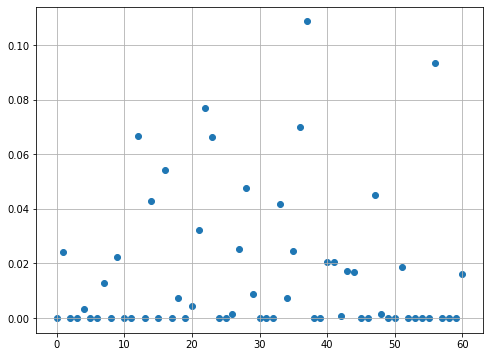

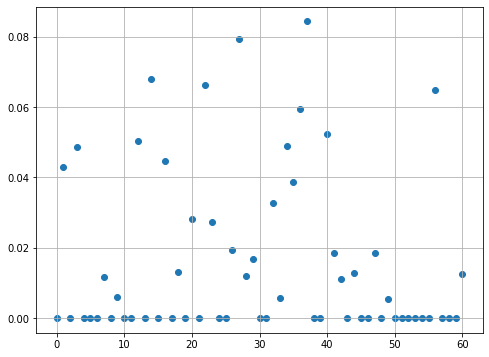

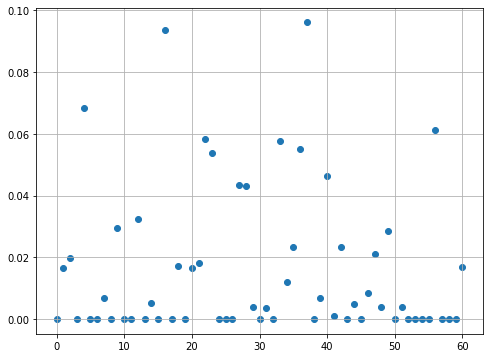

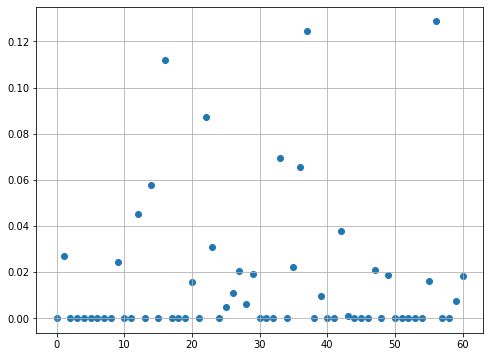

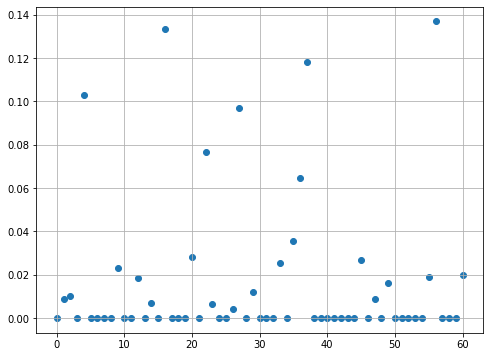

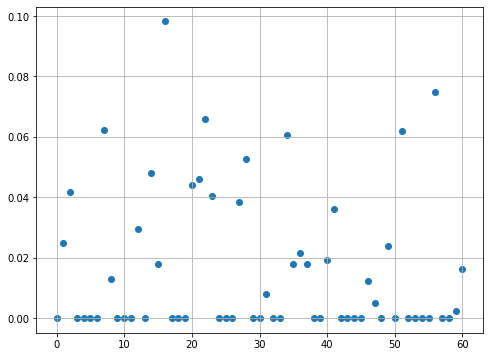

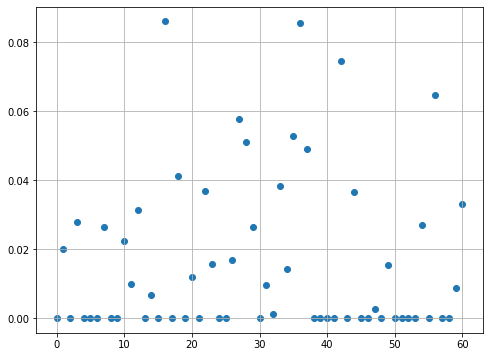

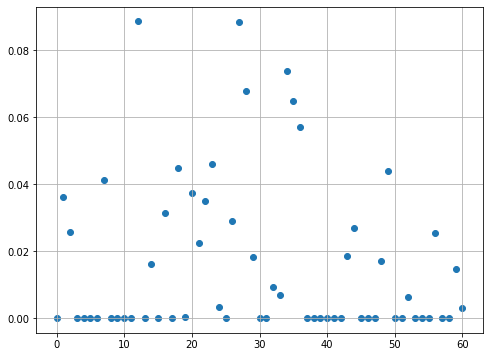

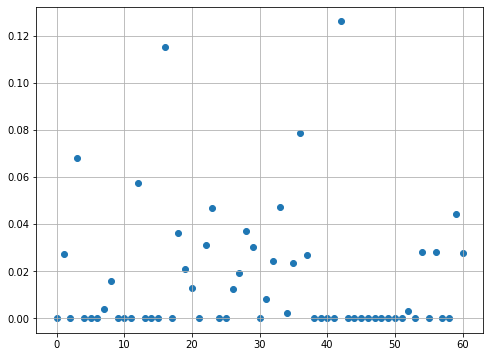

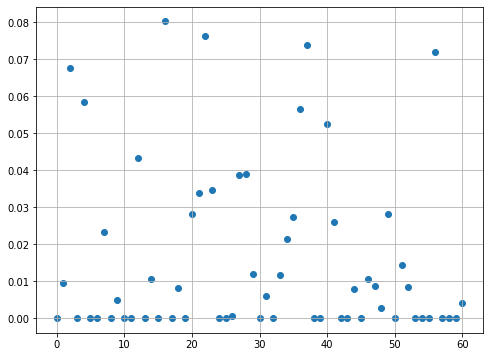

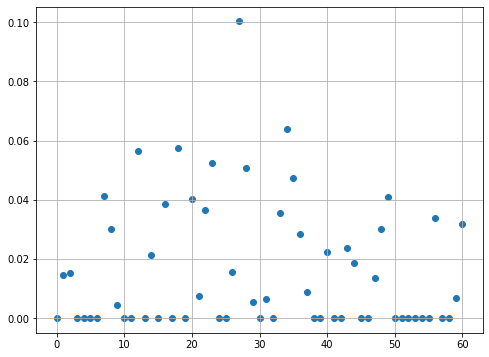

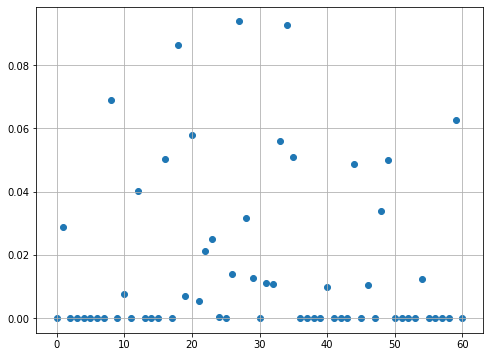

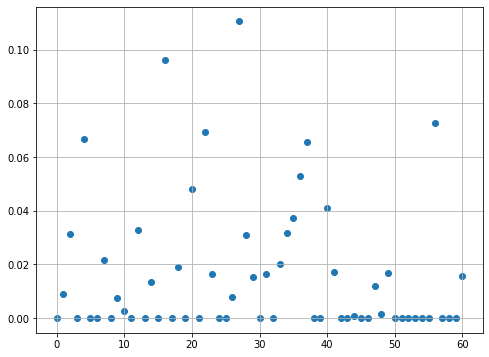

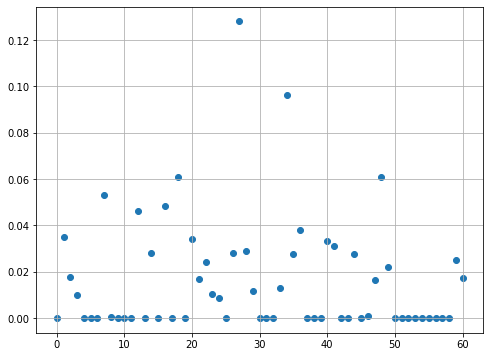

In [87]:
for ls in lss[np.where(non_zero == 0)[0]]:
    plt.scatter(np.arange(61), ls)
    plt.grid()
    plt.show()